### Homework 5 by Jung 2018. Autumn

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import fsolve
import statsmodels.api as sm
import pandas as pd
import warnings
#warnings.filterwarnings("ignore")

### 0. Actual Data (Korea)

In [2]:

df = pd.read_pickle("Data.pkl")
df= df[83:-1]
df[df.columns[1:]] = df[df.columns[1:]].astype(float)
df.drop(df.columns[2:4], axis=1, inplace=True)
df.columns = ['T', 'Y','C','I','G','Ex','Im','Emp','AvgH']
#df['NX'] = df['Ex']-df['Im']
df['H'] = df['Emp']*df['AvgH']
df['Y/H'] = df['Y']/df['H']

In [3]:
df.head()

,T,Y,C,I,G,Ex,Im,Emp,AvgH,H,Y/H
83,1980 1,35936.3,26446.8,10209.3,9595.5,4463.1,8928.7,13760.0,52.0,715520.0,0.050224
84,1980 2,41193.0,25833.4,13259.8,9777.8,5338.1,9656.8,14736.0,56.6,834057.6,0.049389
85,1980 3,41269.1,26737.2,12769.3,10078.5,5509.8,8932.9,14361.0,53.0,761133.0,0.054221
86,1980 4,44666.6,28433.8,13433.7,10078.1,6211.1,9835.7,11876.0,53.9,640116.4,0.069779
87,1981 1,37305.9,27052.2,9709.9,10492.0,5567.0,8931.1,13827.0,53.6,741127.2,0.050337


In [4]:
# Deviation from HP trend
dff = df.copy()
for col in df.columns[1:]:
    cycle,_ = sm.tsa.filters.hpfilter(np.log(df[[col]]), 1600)
    dff[[col]] = cycle

In [5]:
def Stat(df_): # Report Table1
    V_stat = pd.DataFrame(df_.std()*100)
    V_stat.columns = ['SD']
    V_stat['RelativeSD'] = V_stat.SD/V_stat.loc['Y','SD']
    V_stat['Autocorr'] = 0
    V_stat = V_stat.reindex(columns=[*V_stat.columns.tolist(), 'CrossCorr-2','CrossCorr-1','CrossCorr','CrossCorr+1','CrossCorr+2'],\
                   fill_value=0)
    crosscorr = ['CrossCorr-2','CrossCorr-1','CrossCorr','CrossCorr+1','CrossCorr+2']
    for nm, col in df_.iteritems():
        if nm != 'T':
            V_stat.loc[nm,'Autocorr'] = col.autocorr(1)
            for i in range(5):
                if i <2:
                    V_stat.loc[nm,crosscorr[i]] = np.corrcoef(df_.Y[2-i:], col[:i-2])[0,1]
                elif i >=3:
                    V_stat.loc[nm,crosscorr[i]] = np.corrcoef(df_.Y[:2-i], col[i-2:])[0,1]
                else:
                    V_stat.loc[nm,crosscorr[i]] = np.corrcoef(df_.Y, col)[0,1]
    return V_stat

In [6]:
Actual_stat = Stat(dff)
Actual_stat = Actual_stat.reindex(['Y', 'C', 'I', 'H', 'Emp', 'AvgH', 'Y/H', 'G', 'Ex', 'Im'])
Actual_stat = Actual_stat.round(2)
Actual_stat

,SD,RelativeSD,Autocorr,CrossCorr-2,CrossCorr-1,CrossCorr,CrossCorr+1,CrossCorr+2
Y,4.70,1.00,-0.24,-0.00,-0.24,1.00,-0.24,-0.00
C,2.57,0.55,0.25,-0.01,-0.25,0.38,0.53,0.01
I,11.34,2.42,-0.25,0.06,-0.12,0.92,-0.40,0.06
H,5.02,1.07,-0.18,0.33,0.14,0.46,-0.55,0.30
Emp,3.66,0.78,-0.02,0.00,0.38,0.43,-0.48,-0.01
AvgH,2.56,0.55,-0.39,0.64,-0.28,0.29,-0.41,0.61
Y/H,5.06,1.08,-0.01,-0.33,-0.36,0.47,0.32,-0.30
G,3.17,0.67,-0.18,-0.03,-0.48,0.59,-0.10,-0.03
Ex,6.92,1.47,0.17,0.02,-0.20,0.66,-0.25,0.09
Im,7.38,1.57,0.61,0.37,0.19,0.43,0.05,0.30


In [7]:
print('Relative SD of H over w : %0.2f' %(Actual_stat.loc['H','SD']/Actual_stat.loc['Y/H','SD']))

Relative SD of H over w : 0.99


In [8]:
print('Correlation of H with w : %0.2f' %(np.corrcoef(dff.H, dff['Y/H'])[0,1]))

Correlation of H with w : -0.57


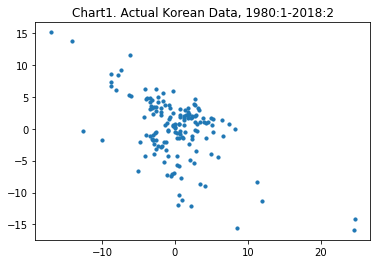

In [9]:
plt.scatter(dff['Y/H']*100, dff['H']*100, s=10)
plt.title('Chart1. Actual Korean Data, 1980:1-2018:2')
plt.show()

### 1. Standard Model

Set parameters 

In [10]:
beta = 0.99; theta = 0.36; delta = 0.025; rho = 0.95; sigma = 0.007

Sovle for Steady State

In [11]:
Hbar = 1/3
Kbar = (Hbar**(theta-1)*(1/beta -(1-delta))/theta)**(1/(theta-1))
Ybar = Kbar**theta*Hbar**(1-theta)
Cbar = Ybar - delta*Kbar
Zbar = 0
mu = (1-Hbar)*(1-theta)*Ybar/Hbar/Cbar
print('Kbar: %0.2f' %Kbar)
print('Ybar: %0.2f' %Ybar)
print('Cbar: %0.2f' %Cbar)
print('Zbar: %0.2f' %Zbar)
print('mu  : %0.2f' %mu)

Kbar: 12.66
Ybar: 1.23
Cbar: 0.92
Zbar: 0.00
mu  : 1.72


##### LQ Method

In [12]:
def fnU(var): # solve for utility fn. value given Wmat
    [Z, K, K_, H] = var
    return np.log( np.exp(Z)*K**theta*H**(1-theta)+(1-delta)*K - K_) + mu*np.log(1-H)

In [13]:
def fnJH(fnU, var): # Solve for Jacobian & Hessian, var must be a list
    mar = 0.00001 # marginal increase/decrease
    dim = len(var)
    Jaco = np.zeros(dim)
    #fnUss= fnU(var)
    for ii in range(dim):
        var_f = var.copy()
        var_b = var.copy()
        var_f[ii] = var[ii]+mar
        var_b[ii] = var[ii]-mar
        Jaco[ii] = (fnU(var_f)-fnU(var_b))/mar/2
    Hessian =  np.zeros((dim,dim))   
    for ii in range(dim):
        for jj in range(dim):
            var_ii = var.copy(); var_ij = var.copy()
            var_ji = var.copy(); var_jj = var.copy()
            if ii==jj:
                var_ii[ii] = var[ii]+mar
                #var_ij = var; var_ji = var; 
                var_jj[ii] = var[ii]-mar
                Hessian[ii,jj] = (fnU(var_ii)-fnU(var_ij)-fnU(var_ji)+fnU(var_jj))/mar/mar
            else:
                var_ii[ii] = var[ii]+mar; var_ii[jj] = var[jj]+mar
                var_ij[jj] = var[jj]+mar; var_ij[ii] = var[ii]-mar
                var_ji[ii] = var[ii]+mar; var_ji[jj] = var[jj]-mar
                var_jj[ii] = var[ii]-mar; var_jj[jj] = var[jj]-mar
                Hessian[ii,jj] = (fnU(var_ii)-fnU(var_ij)-fnU(var_ji)+fnU(var_jj))/mar/mar/2/2
    Hessian = (Hessian+Hessian.T)/2
    return Jaco[:,np.newaxis], Hessian

In [14]:
# Make Q
Wbar = np.array([Zbar, Kbar, Kbar, Hbar])[:,np.newaxis]
Rmat = fnU(list(Wbar))
Jmat, Hmat = fnJH(fnU, list(Wbar))

Q11 = Rmat -Wbar.T@Jmat +Wbar.T@Hmat@Wbar/2
Q12 = (Jmat-Hmat@Wbar)/2
Q22 = Hmat/2
Q = np.concatenate((np.concatenate((Q11,Q12.T),axis=1),np.concatenate((Q12,Q22),axis=1)),axis=0)
Q

array([[-1.63818941,  0.6724089 ,  1.10021763, -1.08919095,  1.93652086],
       [ 0.6724089 , -0.23184288, -0.72066464,  0.73238263, -0.44516293],
       [ 1.10021763, -0.72066464, -0.60618455,  0.59916461, -1.38367498],
       [-1.08919095,  0.73238263,  0.59916461, -0.59317329,  1.40617448],
       [ 1.93652086, -0.44516293, -1.38367498,  1.40617448, -6.66430189]])

In [15]:
# Number of variables
l_exo = 1
l_state = 1
l_f = 1+ l_exo+l_state
l_d = 2
l_all = l_f+l_d

In [16]:
# Make B
B = np.zeros((l_f ,l_f+l_d))
B[0,0] =1
B[np.arange(1,l_exo+1),np.arange(1,l_exo+1)] = rho
B[np.arange(1+l_exo,1+l_exo+l_state), np.arange(1+l_exo+l_state,1+l_exo+l_state+l_state)]=1
B

array([[1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.95, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  ]])

In [17]:
tol = 0.0001

P0 = np.ones((l_f,l_f))
#P0 = np.zeros((l_f,l_f))
Ppre = P0

start_time = time.time()
for i in range(2000):
    Msigma = np.zeros((B.shape[1],B.shape[1]))
    Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@np.ones((1,1))*sigma**2)
    #Msigma

    M = B.T@Ppre@B + Msigma
    #M
    
    P = Q[:l_f,:l_f] + beta*M[:l_f,:l_f] -((Q[:l_f,l_f:]+beta*M[:l_f,l_f:]) @ np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @\
        (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T)
    dist = np.max(np.abs(P.flatten() - Ppre.flatten()))
    if dist < tol:
        print('Total number of iterations: %d' %(i+1))
        print('Total running time: %0.3f seconds' % (time.time() - start_time))
        print('       ')
        Msigma = np.zeros((B.shape[1],B.shape[1]))
        Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@np.ones((1,1))*sigma**2)
        M = B.T@P@B + Msigma
        break
    Ppre = P
    if (i+1)%1000 ==0:
        print('%d times running' %(i+1))
        print('Iteration gap : %0.3f' %(dist))
        if i==1999:
            print('The maximum iteration number has reached')
            print('Total running time: %0.3f seconds' % (time.time() - start_time))
            print('       ')

policy_f = -np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @ (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T
policy_f # policy fn. shape(d,s)

Total number of iterations: 910
Total running time: 0.049 seconds
       


array([[ 0.58742189,  1.43259737,  0.95361147],
       [ 0.41452782,  0.23548137, -0.0064119 ]])

In [18]:
policy_f @ np.array([1,Zbar,Kbar])[:,np.newaxis]

array([[12.66308451],
       [ 0.33333333]])

##### Log-Linearization

In [19]:
# exo: Z
# state: K
# endo: H
Rbar = theta*Ybar/Kbar+1-delta

# Define Matrix
# 1. equil. equ.
exo_f = [[-1 + theta*Ybar/Kbar/Rbar], [0]]
state_f = [[-theta + theta*Ybar/Kbar/Rbar*(theta-1)], [-Kbar]]
#endo_f = [[theta + theta*Ybar/Kbar/Rbar*(1-theta)], [0]] #indivisible labor case
endo_f = [[+(Hbar/(1-Hbar)+theta) + theta*Ybar/Kbar/Rbar*(1-theta)], [0]] #standard model
exo = [[1], [Ybar -Cbar]]
state = [[theta], [Ybar*theta -Cbar*theta +(1-delta)*Kbar]]
#endo = [[-theta], [+Ybar*(1-theta) +Cbar*theta]] #indivisible labor case
endo = [[-(Hbar/(1-Hbar)+theta)], [+Ybar*(1-theta) +Cbar*(Hbar/(1-Hbar)+theta)]] #standard model
# 2. exo process
exo_process = [rho]

# to array
Mlist = [exo_f, state_f, endo_f, exo, state, endo, exo_process]
for i, x in enumerate(Mlist):
    Mlist[i] = np.array(x)
[exo_f, state_f, endo_f, exo, state, endo, exo_process] = Mlist

phi1 = state[0]/state_f[0]; phi2=endo_f[0]/state_f[0]; phi3=endo[0]/state_f[0]; 
phi4=exo_f[0]/state_f[0]; phi5=exo[0]/state_f[0]

eta1 = state[1]/state_f[1]; eta2=endo[1]/state_f[1]; eta3=exo[1]/state_f[1]

# decision rull coeff.
aa = 1
bb = eta1- eta2/phi2 +phi3/phi2
cc = phi3/phi2*eta1 -eta2*phi1/phi2

psi1 = (-bb - np.sqrt(bb**2 - 4*aa*cc))/2/aa
psi3 = -psi1/eta2 - eta1/eta2

dd = 1+phi2*psi3 - phi2/eta2*exo_process - phi3/eta2
ee = eta3/eta2*phi2*exo_process + phi3*eta3/eta2 -phi4*exo_process -phi5 
psi2 = ee/dd
psi4 = -psi2/eta2 -eta3/eta2

policy_loglin = np.append(np.append(psi1,psi2)[np.newaxis,:],np.append(psi3,psi4)[np.newaxis,:], axis=0)
policy_loglin

array([[ 0.95366931,  0.1131987 ],
       [-0.24312359,  0.70697974]])

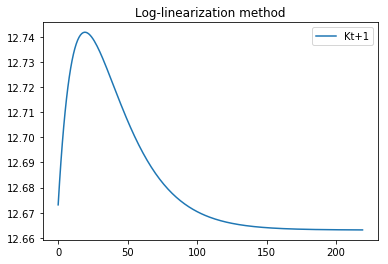

In [20]:
# Log-Lin
# Impulse response to Z innovation size 1
Zt_pre = 0
Kt_pre = 0
periods = 220

Z_shocks = np.array([1*sigma]+[0]*(periods-1))

K_f_series = np.zeros(periods); H_series = np.zeros(periods)
Z_series = np.zeros(periods)
for t in range(periods):
    #Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t
    Zt_pre = rho*Zt_pre + Z_shocks[t]
    d_t = policy_loglin @ np.array([Kt_pre,Zt_pre])[:,np.newaxis]
    Kt_pre = d_t[0][0]
    H_series[t] = d_t[1]
    K_f_series[t] = Kt_pre
    Z_series[t] = Zt_pre

K_f_series_loglin = np.exp(K_f_series)*Kbar
H_series_loglin = np.exp(H_series)*Hbar
Z_series_loglin = Z_series

K_series_loglin = np.append(Kbar, K_f_series_loglin[:-1])
Y_series_loglin = np.exp(Z_series_loglin)*K_series_loglin**theta*H_series_loglin**(1-theta)
I_series_loglin = K_f_series_loglin - (1-delta)*K_series_loglin
C_series_loglin = Y_series_loglin - I_series_loglin
Y_H_series_loglin = Y_series_loglin/H_series_loglin
R_series_loglin = Y_series_loglin/K_series_loglin*theta-delta

plt.plot(np.arange(220),K_f_series_loglin, label='Kt+1')
plt.legend()
plt.title('Log-linearization method')
plt.show()

##### Results

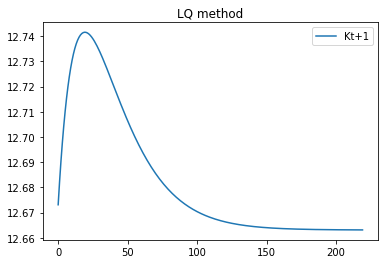

In [21]:
# Impulse response to Z innovation size 1
Zt_pre = Zbar
Kt_pre = Kbar
periods = 220

Z_shocks = np.array([1*sigma]+[0]*(periods-1))

K_f_series = np.zeros(periods); H_series = np.zeros(periods)
Z_series = np.zeros(periods)
for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Kt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    H_series[t] = d_t[1]
    K_f_series[t] = Kt_pre
    Z_series[t] = Zt_pre

K_series = np.append(Kbar, K_f_series[:-1])
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta


plt.plot(np.arange(220),K_f_series, label='Kt+1')
plt.legend()
plt.title('LQ method')
plt.show()

In [22]:
def plot_irf(txt):
    fig = plt.figure(figsize=(15, 5))
    ax = plt.subplot(231)
    ax.plot(np.arange(220),Y_series,'b',label='LQ')
    ax.plot(np.arange(220),Y_series_loglin,'r',label='LL')
    ax_ = ax.twinx()
    ax_.plot(np.arange(220),Y_series-Y_series_loglin,'k:',label='LQ-LL')
    plt.title('Y%s' %txt)
    ax.legend(); ax_.legend(loc='right')
    
    ax = plt.subplot(232)
    ax.plot(np.arange(220),C_series,'b',label='LQ')
    ax.plot(np.arange(220),C_series_loglin,'r',label='LL')
    ax_ = ax.twinx()
    ax_.plot(np.arange(220),C_series-C_series_loglin,'k:',label='LQ-LL')
    plt.title('C%s' %txt)
    ax.legend(); ax_.legend(loc='right')
    
    ax = plt.subplot(233)
    ax.plot(np.arange(220),I_series,'b',label='LQ')
    ax.plot(np.arange(220),I_series_loglin,'r',label='LL')
    ax_ = ax.twinx()
    ax_.plot(np.arange(220),I_series-I_series_loglin,'k:',label='LQ-LL')
    plt.title('I%s' %txt)
    ax.legend(); ax_.legend(loc='right')
    
    ax = plt.subplot(234)
    ax.plot(np.arange(220),K_series,'b',label='LQ')
    ax.plot(np.arange(220),K_series_loglin,'r',label='LL')
    ax_ = ax.twinx()
    ax_.plot(np.arange(220),K_series-K_series_loglin,'k:',label='LQ-LL')
    plt.title('K%s' %txt)
    ax.legend(); ax_.legend(loc='right')
    
    ax = plt.subplot(235)
    ax.plot(np.arange(220),Y_H_series,'b',label='LQ')
    ax.plot(np.arange(220),Y_H_series_loglin,'r',label='LL')
    ax_ = ax.twinx()
    ax_.plot(np.arange(220),Y_H_series-Y_H_series_loglin,'k:',label='LQ-LL')
    plt.title('Y/H%s' %txt)
    ax.legend(); ax_.legend(loc='right')

    ax = plt.subplot(236)
    ax.plot(np.arange(220),R_series,'b',label='LQ')
    ax.plot(np.arange(220),R_series_loglin,'r',label='LL')
    ax_ = ax.twinx()
    ax_.plot(np.arange(220),R_series-R_series_loglin,'k:',label='LQ-LL')
    plt.title('R%s' %txt)
    ax.legend(); ax_.legend(loc='right')
    plt.tight_layout()
    plt.show()

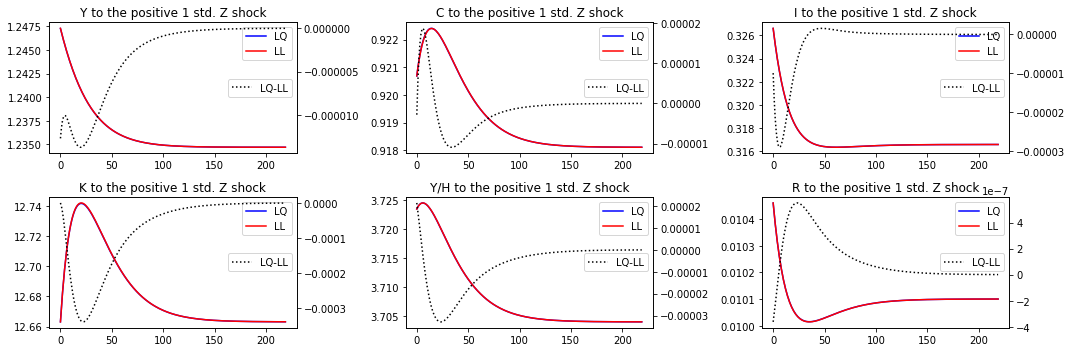

In [23]:
plot_irf(' to the positive 1 std. Z shock')

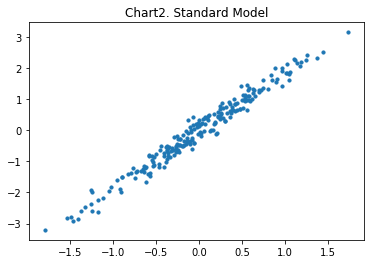

In [24]:
# Simulation
Zt_pre = 0
Kt_pre = Kbar
periods = 220

Z_shocks = np.random.normal(0,sigma,periods)
K_f_series = np.zeros(periods); H_series = np.zeros(periods)
Z_series = np.zeros(periods)

for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Kt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    H_series[t] = d_t[1]
    K_f_series[t] = Kt_pre
    Z_series[t] = Zt_pre

#plt.plot(np.arange(220),K_f_series)
#plt.show()

K_series = np.append(Kbar, K_f_series[:-1])
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta

K_series,_ = sm.tsa.filters.hpfilter(np.log(K_series), 1600)
Y_series,_ = sm.tsa.filters.hpfilter(np.log(Y_series), 1600)
I_series,_ = sm.tsa.filters.hpfilter(np.log(I_series), 1600)
C_series,_ = sm.tsa.filters.hpfilter(np.log(C_series), 1600)
H_series,_ = sm.tsa.filters.hpfilter(np.log(H_series), 1600)
Y_H_series,_ = sm.tsa.filters.hpfilter(np.log(Y_H_series), 1600)
R_series,_ = sm.tsa.filters.hpfilter(np.log(R_series), 1600)

plt.scatter(Y_H_series*100, Y_series*100, s=10)
plt.title('Chart2. Standard Model')
plt.show()

In [25]:
# Repeat Simulation
rep = 100
periods = 240

Z_shocks = np.random.normal(0,sigma,(rep,periods))
K_f_series = np.zeros((rep,periods)); H_series = np.zeros((rep,periods))
Z_series = np.zeros((rep,periods))

for rr in range(rep):
    Zt_pre = 0
    Kt_pre = Kbar
    for t in range(periods):
        Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[rr, t]
        d_t = policy_f @ np.array([1,Zt_pre,Kt_pre])[:,np.newaxis]
        Kt_pre = d_t[0]
        H_series[rr,t] = d_t[1]
        K_f_series[rr,t] = Kt_pre
        Z_series[rr,t] = Zt_pre


K_series = np.append(np.ones((rep,1))*Kbar, K_f_series[:,:-1], axis=1)
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta

simdata = {}; sim_sd={}
simlist = ['Y','C','I','H','Y_H','R']
varseries = [Y_series, C_series, I_series, H_series, Y_H_series, R_series]
for i, ser in enumerate(varseries):
    for rr in range(rep):
        cycle,_ = sm.tsa.filters.hpfilter(np.log(ser[rr,:]), 1600)
        ser[rr,:] = cycle
    simdata[simlist[i]] = np.mean(ser, axis=0)
    sim_sd[simlist[i]] = np.mean(np.std(ser, axis=1))

for rr in range(rep):
    if rr==0:
        stat = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
    else:
        tmp = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
        stat += tmp
stat= stat/rep
stat= stat.round(2)

corr_h_w = np.zeros(rep)
for rr in range(rep):
    corr_h_w[rr] = np.corrcoef(H_series[rr,:], Y_H_series[rr,:])[0,1]
    
print('%% S.D of Y : %0.2f' % (sim_sd['Y']*100))
print('S.D of C vs Y : %0.2f' % (sim_sd['C']/sim_sd['Y']))
print('S.D of I vs Y : %0.2f' % (sim_sd['I']/sim_sd['Y']))
print('S.D of H vs Y : %0.2f' % (sim_sd['H']/sim_sd['Y']))
print('S.D of Y_H vs Y : %0.2f' % (sim_sd['Y_H']/sim_sd['Y']))
print('S.D of H vs Y_H : %0.2f' % (sim_sd['H']/sim_sd['Y_H']))
print('Corr(H, Y_H)    : %0.2f' % (np.mean(corr_h_w)))

#plt.scatter(simdata['Y_H']*100, simdata['Y']*100, s=10)
#lt.show()

% S.D of Y : 1.29
S.D of C vs Y : 0.32
S.D of I vs Y : 3.14
S.D of H vs Y : 0.49
S.D of Y_H vs Y : 0.53
S.D of H vs Y_H : 0.92
Corr(H, Y_H)    : 0.93


In [26]:
stat

,SD,RelativeSD,Autocorr,CrossCorr-2,CrossCorr-1,CrossCorr,CrossCorr+1,CrossCorr+2
Y,1.29,1.00,0.70,0.46,0.70,1.00,0.70,0.46
C,0.41,0.32,0.80,0.26,0.54,0.89,0.76,0.63
I,4.06,3.14,0.69,0.50,0.72,0.99,0.65,0.39
H,0.63,0.49,0.69,0.51,0.73,0.98,0.63,0.35
Y_H,0.69,0.53,0.73,0.39,0.66,0.98,0.75,0.54
R,4.59,3.55,0.69,0.53,0.73,0.96,0.59,0.30


### 2. Nonseparable leisure

Set parameters 

In [27]:
beta = 0.99; theta = 0.36; delta = 0.025; rho = 0.95; sigma = 0.007
alpha0 = 0.35; eta = 0.10

Sovle for Steady State

In [28]:
Hbar = 1/3
Kbar = (Hbar**(theta-1)*(1/beta -(1-delta))/theta)**(1/(theta-1))
Ybar = Kbar**theta*Hbar**(1-theta)
Cbar = Ybar - delta*Kbar
Zbar = 0
mu = np.exp(Zbar)*(1-theta)*Ybar/Hbar/Cbar*(1-Hbar)*(1/beta-(1-eta)) / (eta*(1-alpha0)-alpha0*(1-eta)+alpha0/beta)
Xbar = (1-Hbar)/eta
print('Kbar: %0.2f' %Kbar)
print('Ybar: %0.2f' %Ybar)
print('Cbar: %0.2f' %Cbar)
print('Zbar: %0.2f' %Zbar)
print('mu  : %0.2f' %mu)
print('Xbar: %0.2f' %Xbar)

Kbar: 12.66
Ybar: 1.23
Cbar: 0.92
Zbar: 0.00
mu  : 1.83
Xbar: 6.67


In [29]:
def fnU(var): # solve for utility fn. value given Wmat
    [Z, K, X, K_, X_] = var
    H = 1-(X_-(1-eta)*X)
    return np.log( np.exp(Z)*K**theta*H**(1-theta)+(1-delta)*K - K_) + mu*np.log(alpha0*(1-H) +eta*(1-alpha0)*X)

In [30]:
fnU([Zbar, Kbar, Xbar, Kbar, Xbar])

-0.8276517007349621

In [31]:
def fnJH(fnU, var): # Solve for Jacobian & Hessian, var must be a list
    mar = 0.00001 # marginal increase/decrease
    dim = len(var)
    Jaco = np.zeros(dim)
    #fnUss= fnU(var)
    for ii in range(dim):
        var_f = var.copy()
        var_b = var.copy()
        var_f[ii] = var[ii]+mar
        var_b[ii] = var[ii]-mar
        Jaco[ii] = (fnU(var_f)-fnU(var_b))/mar/2
    Hessian =  np.zeros((dim,dim))   
    for ii in range(dim):
        for jj in range(dim):
            var_ii = var.copy(); var_ij = var.copy()
            var_ji = var.copy(); var_jj = var.copy()
            if ii==jj:
                var_ii[ii] = var[ii]+mar
                #var_ij = var; var_ji = var; 
                var_jj[ii] = var[ii]-mar
                Hessian[ii,jj] = (fnU(var_ii)-fnU(var_ij)-fnU(var_ji)+fnU(var_jj))/mar/mar
            else:
                var_ii[ii] = var[ii]+mar; var_ii[jj] = var[jj]+mar
                var_ij[jj] = var[jj]+mar; var_ij[ii] = var[ii]-mar
                var_ji[ii] = var[ii]+mar; var_ji[jj] = var[jj]-mar
                var_jj[ii] = var[ii]-mar; var_jj[jj] = var[jj]-mar
                Hessian[ii,jj] = (fnU(var_ii)-fnU(var_ij)-fnU(var_ji)+fnU(var_jj))/mar/mar/2/2
    Hessian = (Hessian+Hessian.T)/2
    return Jaco[:,np.newaxis], Hessian

In [32]:
# Make Q
Wbar = np.array([Zbar, Kbar, Xbar, Kbar, Xbar])[:,np.newaxis]
Rmat = fnU(list(Wbar))
Jmat, Hmat = fnJH(fnU, list(Wbar))

Q11 = Rmat -Wbar.T@Jmat +Wbar.T@Hmat@Wbar/2
Q12 = (Jmat-Hmat@Wbar)/2
Q22 = Hmat/2
Q = np.concatenate((np.concatenate((Q11,Q12.T),axis=1),np.concatenate((Q12,Q22),axis=1)),axis=0)
Q

array([[-4.6384715 ,  0.22724569, -0.28332537, -2.61768507,  0.31698307,
         3.1067406 ],
       [ 0.22724569, -0.23186175, -0.7206645 , -0.4006466 ,  0.73238249,
         0.44516293],
       [-0.28332537, -0.7206645 , -0.60619454, -1.24530858,  0.59916461,
         1.38367526],
       [-2.61768507, -0.4006466 , -1.24530858, -3.9581971 ,  1.2655571 ,
         4.43519305],
       [ 0.31698307,  0.73238249,  0.59916461,  1.2655571 , -0.59317329,
        -1.40617448],
       [ 3.1067406 ,  0.44516293,  1.38367526,  4.43519305, -1.40617448,
        -4.98004415]])

In [33]:
# Number of variables
l_exo = 1
l_state = 2
l_f = 1+ l_exo+l_state
l_d = 2
l_all = l_f+l_d

In [34]:
# Make B
B = np.zeros((l_f ,l_f+l_d))
B[0,0] =1
B[np.arange(1,l_exo+1),np.arange(1,l_exo+1)] = rho
B[np.arange(1+l_exo,1+l_exo+l_state), np.arange(1+l_exo+l_state,1+l_exo+l_state+l_state)]=1
B

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.95, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

In [35]:
tol = 0.0001

P0 = np.ones((l_f,l_f))
#P0 = np.zeros((l_f,l_f))
Ppre = P0

start_time = time.time()
for i in range(2000):
    Msigma = np.zeros((B.shape[1],B.shape[1]))
    Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@np.ones((1,1))*sigma**2)
    #If there are more than 2 exo shocks, then modify above line

    M = B.T@Ppre@B + Msigma
    #M
    
    P = Q[:l_f,:l_f] + beta*M[:l_f,:l_f] -((Q[:l_f,l_f:]+beta*M[:l_f,l_f:]) @ np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @\
        (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T)
    dist = np.max(np.abs(P.flatten() - Ppre.flatten()))
    if dist < tol:
        print('Total number of iterations: %d' %(i+1))
        print('Total running time: %0.3f seconds' % (time.time() - start_time))
        print('       ')
        Msigma = np.zeros((B.shape[1],B.shape[1]))
        Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@np.ones((1,1))*sigma**2)
        M = B.T@P@B + Msigma
        break
    Ppre = P
    if (i+1)%1000 ==0:
        print('%d times running' %(i+1))
        print('Iteration gap : %0.3f' %(dist))
        if i==1999:
            print('The maximum iteration number has reached')
            print('Total running time: %0.3f seconds' % (time.time() - start_time))
            print('       ')

policy_f = -np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @ (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T
policy_f # policy fn. shape(d,s)

Total number of iterations: 919
Total running time: 0.051 seconds
       


array([[ 0.16668334,  1.72997226,  0.94646124,  0.07669237],
       [ 0.78796106, -0.37273744,  0.00966719,  0.86344338]])

In [36]:
policy_f @ np.array([1,Zbar,Kbar, Xbar])[:,np.newaxis]

array([[12.66308451],
       [ 6.66666667]])

In [37]:
[1,Zbar,Kbar, Xbar]

[1, 0, 12.663084512717404, 6.666666666666667]

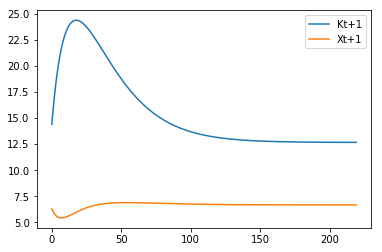

In [38]:
# Impulse response to Z innovation size 1
Zt_pre = Zbar
Kt_pre = Kbar
Xt_pre = Xbar
periods = 220

Z_shocks = np.array([1]+[0]*(periods-1))

K_f_series = np.zeros(periods)
X_f_series = np.zeros(periods)
Z_series = np.zeros(periods)
for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Kt_pre, Xt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    Xt_pre = d_t[1]
    K_f_series[t] = Kt_pre
    X_f_series[t] = Xt_pre
    Z_series[t] = Zt_pre


plt.plot(np.arange(220),K_f_series, label='Kt+1')
plt.plot(np.arange(220),X_f_series, label='Xt+1')
plt.legend()
plt.show()

In [39]:
def plot_irf(txt):
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(231)
    plt.plot(np.arange(220),Y_series)
    plt.title('Y%s' %txt)
    plt.subplot(232)
    plt.plot(np.arange(220),C_series)
    plt.title('C%s' %txt)
    plt.subplot(233)
    plt.plot(np.arange(220),I_series)
    plt.title('I%s' %txt)
    plt.subplot(234)
    plt.plot(np.arange(220),K_series)
    plt.title('K%s' %txt)
    plt.subplot(235)
    plt.plot(np.arange(220),Y_H_series)
    plt.title('Y/H%s' %txt)
    plt.subplot(236)
    plt.plot(np.arange(220),R_series)
    plt.title('R%s' %txt)
    plt.tight_layout()
    plt.show()

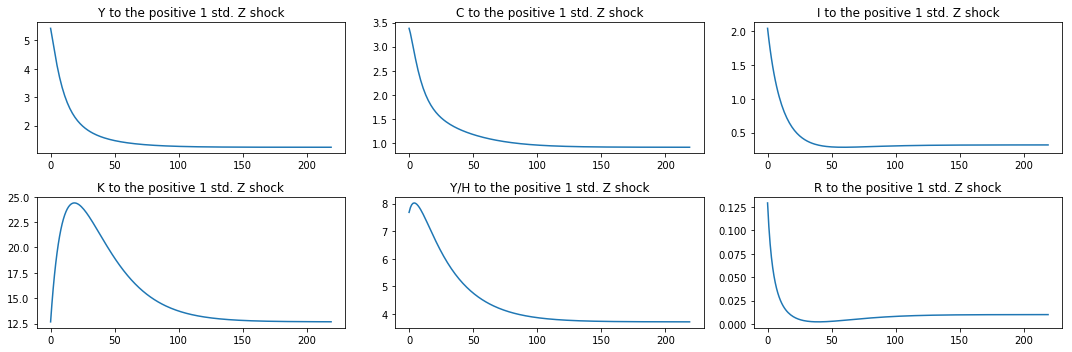

In [40]:
K_series = np.append(Kbar, K_f_series[:-1])
X_series = np.append(Xbar, X_f_series[:-1])
H_series = 1-X_f_series+(1-eta)*X_series
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta


plot_irf(' to the positive 1 std. Z shock')

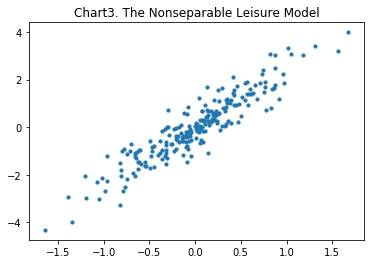

In [41]:
# Simulation
Zt_pre = Zbar
Kt_pre = Kbar
Xt_pre = Xbar
periods = 220

Z_shocks = np.random.normal(0,sigma,periods)
K_f_series = np.zeros(periods)
X_f_series = np.zeros(periods)
Z_series = np.zeros(periods)

for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Kt_pre,Xt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    Xt_pre = d_t[1]
    K_f_series[t] = Kt_pre
    X_f_series[t] = Xt_pre
    Z_series[t] = Zt_pre
    #H_series[t] = d_t[1]


K_series = np.append(Kbar, K_f_series[:-1])
X_series = np.append(Xbar, X_f_series[:-1])
H_series = 1-X_f_series+(1-eta)*X_series
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta

K_series,_ = sm.tsa.filters.hpfilter(np.log(K_series), 1600)
Y_series,_ = sm.tsa.filters.hpfilter(np.log(Y_series), 1600)
I_series,_ = sm.tsa.filters.hpfilter(np.log(I_series), 1600)
C_series,_ = sm.tsa.filters.hpfilter(np.log(C_series), 1600)
H_series,_ = sm.tsa.filters.hpfilter(np.log(H_series), 1600)
Y_H_series,_ = sm.tsa.filters.hpfilter(np.log(Y_H_series), 1600)
R_series,_ = sm.tsa.filters.hpfilter(np.log(R_series), 1600)

plt.scatter(Y_H_series*100, Y_series*100, s=10)
plt.title('Chart3. The Nonseparable Leisure Model')
plt.show()

In [42]:
# Repeat Simulation
rep = 100
periods = 240

Z_shocks = np.random.normal(0,sigma,(rep,periods))
K_f_series = np.zeros((rep,periods))
X_f_series = np.zeros((rep,periods))
Z_series = np.zeros((rep,periods))
#H_series = np.zeros((rep,periods))

for rr in range(rep):
    Zt_pre = Zbar
    Kt_pre = Kbar
    Xt_pre = Xbar
    for t in range(periods):
        Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[rr, t]
        d_t = policy_f @ np.array([1,Zt_pre,Kt_pre,Xt_pre])[:,np.newaxis]
        Kt_pre = d_t[0]
        Xt_pre = d_t[1]
        K_f_series[rr,t] = Kt_pre
        X_f_series[rr,t] = Xt_pre
        Z_series[rr,t] = Zt_pre
        #H_series[rr,t] = d_t[1]

K_series = np.append(np.ones((rep,1))*Kbar, K_f_series[:,:-1], axis=1)
X_series = np.append(np.ones((rep,1))*Xbar, X_f_series[:,:-1], axis=1)
H_series = 1-X_f_series+(1-eta)*X_series
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta

simdata = {}; sim_sd={}
simlist = ['Y','C','I','H','Y_H','R']
varseries = [Y_series, C_series, I_series, H_series, Y_H_series, R_series]
for i, ser in enumerate(varseries):
    for rr in range(rep):
        cycle,_ = sm.tsa.filters.hpfilter(np.log(ser[rr,:]), 1600)
        ser[rr,:] = cycle
    simdata[simlist[i]] = np.mean(ser, axis=0)
    sim_sd[simlist[i]] = np.mean(np.std(ser, axis=1))

for rr in range(rep):
    if rr==0:
        stat = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
    else:
        tmp = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
        stat += tmp
stat= stat/rep
stat= stat.round(2)

corr_h_w = np.zeros(rep)
for rr in range(rep):
    corr_h_w[rr] = np.corrcoef(H_series[rr,:], Y_H_series[rr,:])[0,1]
    
print('%% S.D of Y : %0.2f' % (sim_sd['Y']*100))
print('S.D of C vs Y : %0.2f' % (sim_sd['C']/sim_sd['Y']))
print('S.D of I vs Y : %0.2f' % (sim_sd['I']/sim_sd['Y']))
print('S.D of H vs Y : %0.2f' % (sim_sd['H']/sim_sd['Y']))
print('S.D of Y_H vs Y : %0.2f' % (sim_sd['Y_H']/sim_sd['Y']))
print('S.D of H vs Y_H : %0.2f' % (sim_sd['H']/sim_sd['Y_H']))
print('Corr(H, Y_H)    : %0.2f' % (np.mean(corr_h_w)))

% S.D of Y : 1.52
S.D of C vs Y : 0.30
S.D of I vs Y : 3.21
S.D of H vs Y : 0.65
S.D of Y_H vs Y : 0.40
S.D of H vs Y_H : 1.62
Corr(H, Y_H)    : 0.81


In [43]:
stat

,SD,RelativeSD,Autocorr,CrossCorr-2,CrossCorr-1,CrossCorr,CrossCorr+1,CrossCorr+2
Y,1.52,1.00,0.69,0.43,0.69,1.00,0.69,0.43
C,0.45,0.30,0.80,0.21,0.50,0.87,0.75,0.63
I,4.88,3.21,0.67,0.47,0.70,0.99,0.64,0.36
H,0.99,0.65,0.66,0.50,0.71,0.97,0.58,0.29
Y_H,0.61,0.40,0.78,0.28,0.56,0.92,0.77,0.62
R,5.42,3.56,0.67,0.50,0.71,0.96,0.58,0.28


### 3. RBC with indivisible labor

Set parameters 

In [44]:
beta = 0.99; theta = 0.36; delta = 0.025; rho = 0.95; sigma = 0.007

Solve for Steady State

In [45]:
Hbar = 1/3
Kbar = (Hbar**(theta-1)*(1/beta -(1-delta))/theta)**(1/(theta-1))
Ybar = Kbar**theta*Hbar**(1-theta)
Cbar = Ybar - delta*Kbar
Zbar = 0
mu = np.exp(Zbar)*(1-theta)*Ybar/Hbar/Cbar
print('Kbar: %0.2f' %Kbar)
print('Ybar: %0.2f' %Ybar)
print('Cbar: %0.2f' %Cbar)
print('Zbar: %0.2f' %Zbar)
print('mu  : %0.2f' %mu)

Kbar: 12.66
Ybar: 1.23
Cbar: 0.92
Zbar: 0.00
mu  : 2.58


In [46]:
def fnU(var): # solve for utility fn. value given Wmat
    [Z, K, K_, H] = var
    return np.log( np.exp(Z)*K**theta*H**(1-theta)+(1-delta)*K - K_) - mu*H

In [47]:
fnU([Zbar, Kbar, Kbar, Hbar])

-0.9461201017985518

In [48]:
# Make Q
Wbar = np.array([Zbar, Kbar, Kbar, Hbar])[:,np.newaxis]
Rmat = fnU(list(Wbar))
Jmat, Hmat = fnJH(fnU, list(Wbar))

Q11 = Rmat -Wbar.T@Jmat +Wbar.T@Hmat@Wbar/2
Q12 = (Jmat-Hmat@Wbar)/2
Q22 = Hmat/2
Q = np.concatenate((np.concatenate((Q11,Q12.T),axis=1),np.concatenate((Q12,Q22),axis=1)),axis=0)
Q

array([[-1.5857489 ,  0.67240885,  1.10021767, -1.08919095,  1.2910112 ],
       [ 0.67240885, -0.23184288, -0.72066464,  0.73238263, -0.4451628 ],
       [ 1.10021767, -0.72066464, -0.60618455,  0.59916461, -1.38367512],
       [-1.08919095,  0.73238263,  0.59916461, -0.59317329,  1.40617448],
       [ 1.2910112 , -0.4451628 , -1.38367512,  1.40617448, -4.72776762]])

In [49]:
# Number of variables
l_exo = 1
l_state = 1
l_f = 1+ l_exo+l_state
l_d = 2
l_all = l_f+l_d

In [50]:
# Make B
B = np.zeros((l_f ,l_f+l_d))
B[0,0] =1
B[np.arange(1,l_exo+1),np.arange(1,l_exo+1)] = rho
B[np.arange(1+l_exo,1+l_exo+l_state), np.arange(1+l_exo+l_state,1+l_exo+l_state+l_state)]=1
B

array([[1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.95, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  ]])

In [51]:
tol = 0.0001

P0 = np.ones((l_f,l_f))
#P0 = np.zeros((l_f,l_f))
Ppre = P0

start_time = time.time()
for i in range(2000):
    Msigma = np.zeros((B.shape[1],B.shape[1]))
    Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@np.ones((1,1))*sigma**2)
    #If there are more than 2 exo shocks, then modify above line

    M = B.T@Ppre@B + Msigma
    #M
    
    P = Q[:l_f,:l_f] + beta*M[:l_f,:l_f] -((Q[:l_f,l_f:]+beta*M[:l_f,l_f:]) @ np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @\
        (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T)
    dist = np.max(np.abs(P.flatten() - Ppre.flatten()))
    if dist < tol:
        print('Total number of iterations: %d' %(i+1))
        print('Total running time: %0.3f seconds' % (time.time() - start_time))
        print('       ')
        Msigma = np.zeros((B.shape[1],B.shape[1]))
        Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@np.ones((1,1))*sigma**2)
        M = B.T@P@B + Msigma
        break
    Ppre = P
    if (i+1)%1000 ==0:
        print('%d times running' %(i+1))
        print('Iteration gap : %0.3f' %(dist))
        if i==1999:
            print('The maximum iteration number has reached')
            print('Total running time: %0.3f seconds' % (time.time() - start_time))
            print('       ')

policy_f = -np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @ (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T
policy_f # policy fn. shape(d,s)

Total number of iterations: 927
Total running time: 0.051 seconds
       


array([[ 0.7377373 ,  1.96428839,  0.94174111],
       [ 0.49249429,  0.49007684, -0.01256889]])

In [52]:
print(policy_f @ np.array([1,Zbar,Kbar])[:,np.newaxis])
print([1,Zbar,Kbar,Hbar])

[[12.66308452]
 [ 0.33333333]]
[1, 0, 12.663084512717404, 0.3333333333333333]


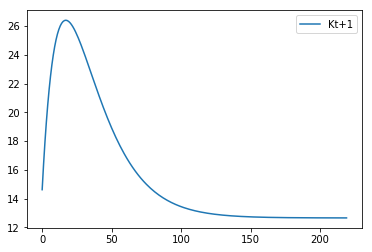

In [53]:
# Impulse response to Z innovation size 1
Zt_pre = Zbar
Kt_pre = Kbar
periods = 220

Z_shocks = np.array([1]+[0]*(periods-1))

K_f_series = np.zeros(periods); H_series = np.zeros(periods)
Z_series = np.zeros(periods)
for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Kt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    H_series[t] = d_t[1]
    K_f_series[t] = Kt_pre
    Z_series[t] = Zt_pre


plt.plot(np.arange(220),K_f_series, label='Kt+1')
plt.legend()
plt.show()

In [54]:
def plot_irf(txt):
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(231)
    plt.plot(np.arange(220),Y_series)
    plt.title('Y%s' %txt)
    plt.subplot(232)
    plt.plot(np.arange(220),C_series)
    plt.title('C%s' %txt)
    plt.subplot(233)
    plt.plot(np.arange(220),I_series)
    plt.title('I%s' %txt)
    plt.subplot(234)
    plt.plot(np.arange(220),K_series)
    plt.title('K%s' %txt)
    plt.subplot(235)
    plt.plot(np.arange(220),Y_H_series)
    plt.title('Y/H%s' %txt)
    plt.subplot(236)
    plt.plot(np.arange(220),R_series)
    plt.title('R%s' %txt)
    plt.tight_layout()
    plt.show()

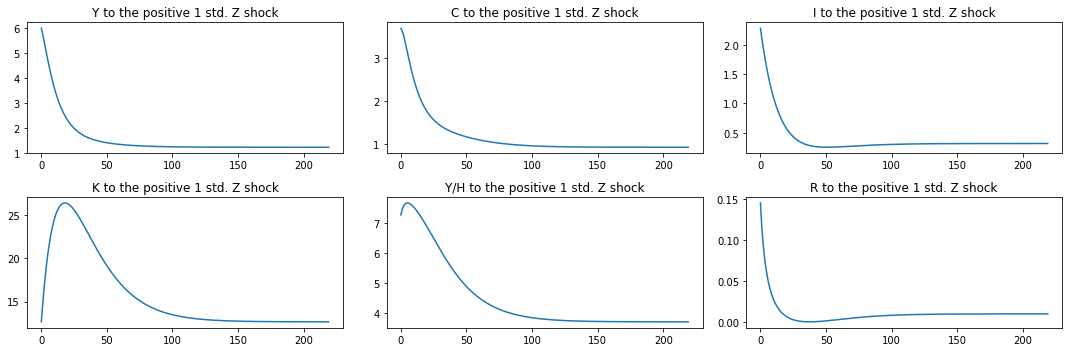

In [55]:
K_series = np.append(Kbar, K_f_series[:-1])
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta


plot_irf(' to the positive 1 std. Z shock')

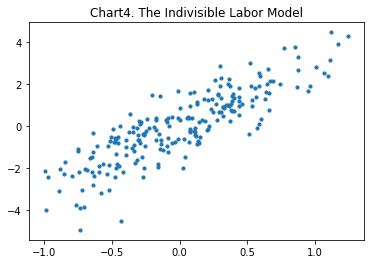

In [56]:
# Simulation
Zt_pre = Zbar
Kt_pre = Kbar
periods = 220

Z_shocks = np.random.normal(0,sigma,periods)
K_f_series = np.zeros(periods)
H_series = np.zeros(periods)
Z_series = np.zeros(periods)

for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Kt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    H_series[t] = d_t[1]
    K_f_series[t] = Kt_pre
    Z_series[t] = Zt_pre


K_series = np.append(Kbar, K_f_series[:-1])
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta

K_series,_ = sm.tsa.filters.hpfilter(np.log(K_series), 1600)
Y_series,_ = sm.tsa.filters.hpfilter(np.log(Y_series), 1600)
I_series,_ = sm.tsa.filters.hpfilter(np.log(I_series), 1600)
C_series,_ = sm.tsa.filters.hpfilter(np.log(C_series), 1600)
H_series,_ = sm.tsa.filters.hpfilter(np.log(H_series), 1600)
Y_H_series,_ = sm.tsa.filters.hpfilter(np.log(Y_H_series), 1600)
R_series,_ = sm.tsa.filters.hpfilter(np.log(R_series), 1600)

plt.scatter(Y_H_series*100, Y_series*100, s=10)
plt.title('Chart4. The Indivisible Labor Model')
plt.show()

In [57]:
# Repeat Simulation
rep = 100
periods = 240

Z_shocks = np.random.normal(0,sigma,(rep,periods))
K_f_series = np.zeros((rep,periods))
H_series = np.zeros((rep,periods))
Z_series = np.zeros((rep,periods))

for rr in range(rep):
    Zt_pre = Zbar
    Kt_pre = Kbar
    for t in range(periods):
        Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[rr, t]
        d_t = policy_f @ np.array([1,Zt_pre,Kt_pre])[:,np.newaxis]
        Kt_pre = d_t[0]
        H_series[rr,t] = d_t[1]
        K_f_series[rr,t] = Kt_pre
        Z_series[rr,t] = Zt_pre

K_series = np.append(np.ones((rep,1))*Kbar, K_f_series[:,:-1], axis=1)
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta

simdata = {}; sim_sd={}
simlist = ['Y','C','I','H','Y_H','R']
varseries = [Y_series, C_series, I_series, H_series, Y_H_series, R_series]
for i, ser in enumerate(varseries):
    for rr in range(rep):
        cycle,_ = sm.tsa.filters.hpfilter(np.log(ser[rr,:]), 1600)
        ser[rr,:] = cycle
    simdata[simlist[i]] = np.mean(ser, axis=0)
    sim_sd[simlist[i]] = np.mean(np.std(ser, axis=1))

for rr in range(rep):
    if rr==0:
        stat = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
    else:
        tmp = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
        stat += tmp
stat= stat/rep
stat= stat.round(2)

corr_h_w = np.zeros(rep)
for rr in range(rep):
    corr_h_w[rr] = np.corrcoef(H_series[rr,:], Y_H_series[rr,:])[0,1]
    
print('%% S.D of Y : %0.2f' % (sim_sd['Y']*100))
print('S.D of C vs Y : %0.2f' % (sim_sd['C']/sim_sd['Y']))
print('S.D of I vs Y : %0.2f' % (sim_sd['I']/sim_sd['Y']))
print('S.D of H vs Y : %0.2f' % (sim_sd['H']/sim_sd['Y']))
print('S.D of Y_H vs Y : %0.2f' % (sim_sd['Y_H']/sim_sd['Y']))
print('S.D of H vs Y_H : %0.2f' % (sim_sd['H']/sim_sd['Y_H']))
print('Corr(H, Y_H)    : %0.2f' % (np.mean(corr_h_w)))

% S.D of Y : 1.76
S.D of C vs Y : 0.29
S.D of I vs Y : 3.24
S.D of H vs Y : 0.76
S.D of Y_H vs Y : 0.29
S.D of H vs Y_H : 2.63
Corr(H, Y_H)    : 0.77


In [58]:
stat

,SD,RelativeSD,Autocorr,CrossCorr-2,CrossCorr-1,CrossCorr,CrossCorr+1,CrossCorr+2
Y,1.76,1.00,0.70,0.45,0.70,1.00,0.70,0.45
C,0.52,0.29,0.80,0.22,0.51,0.86,0.76,0.64
I,5.71,3.24,0.69,0.49,0.72,0.99,0.65,0.38
H,1.34,0.76,0.69,0.51,0.73,0.98,0.63,0.35
Y_H,0.51,0.29,0.81,0.23,0.51,0.87,0.76,0.64
R,6.30,3.57,0.69,0.52,0.73,0.96,0.59,0.30


### 4. Government spending shock

Set parameters 

In [59]:
beta = 0.99; theta = 0.36; delta = 0.025; rho = 0.95; sigma = 0.007
lamb = 0.96; sigma_v = 0.021

Solve for Steady State

In [60]:
Hbar = 1/3
Kbar = (Hbar**(theta-1)*(1/beta -(1-delta))/theta)**(1/(theta-1))
Zbar = 0
Ybar = np.exp(Zbar)*Kbar**theta*Hbar**(1-theta)
Gbar = np.log(0.22*Ybar)
Cbar = Ybar - delta*Kbar - np.exp(Gbar)
mu = (1-Hbar)*np.exp(Zbar)*(1-theta)*Ybar/Hbar/Cbar
print('Kbar: %0.2f' %Kbar)
print('Ybar: %0.2f' %Ybar)
print('Gbar: %0.2f' %Gbar)
print('Cbar: %0.2f' %Cbar)
print('Zbar: %0.2f' %Zbar)
print('mu  : %0.2f' %mu)

Kbar: 12.66
Ybar: 1.23
Gbar: -1.30
Cbar: 0.65
Zbar: 0.00
mu  : 2.44


In [61]:
def fnU(var): # solve for utility fn. value given Wmat
    [Z, G, K, K_, H] = var
    return np.log( np.exp(Z)*K**theta*H**(1-theta)+(1-delta)*K - K_ -np.exp(G)) + mu*np.log(1-H)

In [62]:
fnU([Zbar, Gbar, Kbar, Kbar, Hbar])

-1.4274270474446076

In [63]:
# Make Q
Wbar = np.array([Zbar, Gbar, Kbar, Kbar, Hbar])[:,np.newaxis]
Rmat = fnU(list(Wbar))
Jmat, Hmat = fnJH(fnU, list(Wbar))

Q11 = Rmat -Wbar.T@Jmat +Wbar.T@Hmat@Wbar/2
Q12 = (Jmat-Hmat@Wbar)/2
Q22 = Hmat/2
Q = np.concatenate((np.concatenate((Q11,Q12.T),axis=1),np.concatenate((Q12,Q22),axis=1)),axis=0)
Q

array([[ -4.77152316,   1.87909924,  -0.8972891 ,   2.31855585,
         -2.2953611 ,   4.52459348],
       [  1.87909924,  -0.86884056,   0.40123432,  -1.4649032 ,
          1.47713064,  -1.66821196],
       [ -0.8972891 ,   0.40123432,  -0.29835467,   0.32825104,
         -0.32496866,   0.77037016],
       [  2.31855585,  -1.4649032 ,   0.32825104,  -1.22202581,
          1.20844529,  -2.8126132 ],
       [ -2.2953611 ,   1.47713064,  -0.32496866,   1.20844529,
         -1.19635968,   2.83609053],
       [  4.52459348,  -1.66821196,   0.77037016,  -2.8126132 ,
          2.83609053, -11.45357142]])

In [64]:
# Number of variables
l_exo = 2
l_state = 1
l_f = 1+ l_exo+l_state
l_d = 2
l_all = l_f+l_d

In [65]:
# Make B
B = np.zeros((l_f ,l_f+l_d))
B[0,0] =1
B[np.arange(1,l_exo+1),np.arange(1,l_exo+1)] = [rho, lamb]
B[1:1+l_exo,0] = [(1-rho)*Zbar, (1-lamb)*Gbar]
B[np.arange(1+l_exo,1+l_exo+l_state), np.arange(1+l_exo+l_state,1+l_exo+l_state+l_state)]=1
print(B)

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          0.95        0.          0.          0.          0.        ]
 [-0.05213243  0.          0.96        0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.        ]]


In [66]:
tol = 0.0001

P0 = np.ones((l_f,l_f))
#P0 = np.zeros((l_f,l_f))
Ppre = P0

start_time = time.time()
for i in range(2000):
    Msigma = np.zeros((B.shape[1],B.shape[1]))
    Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@(np.identity(2)@np.array([[sigma**2], [sigma_v**2]])))
    #If there are more than 2 exo shocks, then modify above line

    M = B.T@Ppre@B + Msigma
    #M
    
    P = Q[:l_f,:l_f] + beta*M[:l_f,:l_f] -((Q[:l_f,l_f:]+beta*M[:l_f,l_f:]) @ np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @\
        (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T)
    dist = np.max(np.abs(P.flatten() - Ppre.flatten()))
    if dist < tol:
        print('Total number of iterations: %d' %(i+1))
        print('Total running time: %0.3f seconds' % (time.time() - start_time))
        print('       ')
        Msigma = np.zeros((B.shape[1],B.shape[1]))
        Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@(np.identity(2)@np.array([[sigma**2], [sigma_v**2]])))
        #If there are more than 2 exo shocks, then modify above line
        M = B.T@P@B + Msigma
        break
    Ppre = P
    if (i+1)%1000 ==0:
        print('%d times running' %(i+1))
        print('Iteration gap : %0.3f' %(dist))
        if i==1999:
            print('The maximum iteration number has reached')
            print('Total running time: %0.3f seconds' % (time.time() - start_time))
            print('       ')

policy_f = -np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @ (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T
policy_f # policy fn. shape(d,s)

Total number of iterations: 965
Total running time: 0.060 seconds
       


array([[ 0.50076763,  1.32740888, -0.04167624,  0.95616513],
       [ 0.51903599,  0.18303809,  0.05694054, -0.00880445]])

In [67]:
print(policy_f @ np.array([1,Zbar,Gbar,Kbar])[:,np.newaxis])
print([1,Zbar,Gbar,Kbar,Hbar])

[[12.66308451]
 [ 0.33333333]]
[1, 0, -1.3033108267808444, 12.663084512717404, 0.3333333333333333]


In [68]:
def plot_irf(txt):
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(231)
    plt.plot(np.arange(220),Y_series)
    plt.title('Y%s' %txt)
    plt.subplot(232)
    plt.plot(np.arange(220),C_series)
    plt.title('C%s' %txt)
    plt.subplot(233)
    plt.plot(np.arange(220),I_series)
    plt.title('I%s' %txt)
    plt.subplot(234)
    plt.plot(np.arange(220),K_series)
    plt.title('K%s' %txt)
    plt.subplot(235)
    plt.plot(np.arange(220),Y_H_series)
    plt.title('Y/H%s' %txt)
    plt.subplot(236)
    plt.plot(np.arange(220),R_series)
    plt.title('R%s' %txt)
    plt.tight_layout()
    plt.show()

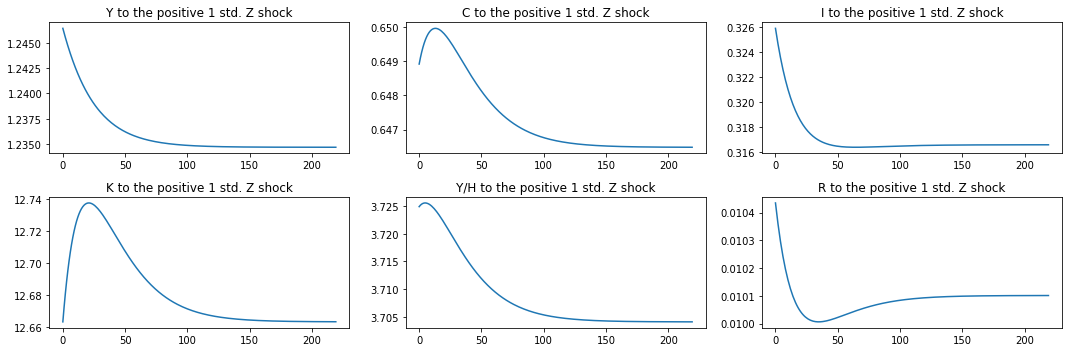

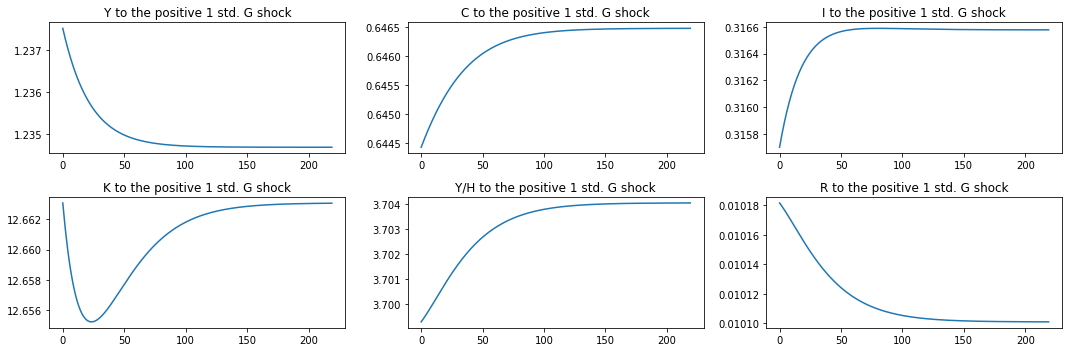

In [69]:
# Impulse response to Z innovation size 1
Zt_pre = Zbar
Gt_pre = Gbar
Kt_pre = Kbar
periods = 220

Z_shocks = np.array([1*sigma]+[0]*(periods-1))
G_shocks = np.array([0]+[0]*(periods-1))

K_f_series = np.zeros(periods); H_series = np.zeros(periods)
Z_series = np.zeros(periods); G_series = np.zeros(periods)
for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    Gt_pre = (1-lamb)*Gbar + lamb*Gt_pre + G_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Gt_pre,Kt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    H_series[t] = d_t[1]
    K_f_series[t] = Kt_pre
    Z_series[t] = Zt_pre
    G_series[t] = Gt_pre

K_series = np.append(Kbar, K_f_series[:-1])
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series - np.exp(G_series)
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta
plot_irf(' to the positive 1 std. Z shock')   

# Impulse response to G innovation size 1
Zt_pre = Zbar
Gt_pre = Gbar
Kt_pre = Kbar

Z_shocks = np.array([0]+[0]*(periods-1))
G_shocks = np.array([1*sigma_v]+[0]*(periods-1))

K_f_series = np.zeros(periods); H_series = np.zeros(periods)
Z_series = np.zeros(periods); G_series = np.zeros(periods)
for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    Gt_pre = (1-lamb)*Gbar + lamb*Gt_pre + G_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Gt_pre,Kt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    H_series[t] = d_t[1]
    K_f_series[t] = Kt_pre
    Z_series[t] = Zt_pre
    G_series[t] = Gt_pre

K_series = np.append(Kbar, K_f_series[:-1])
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series - np.exp(G_series)
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta
plot_irf(' to the positive 1 std. G shock'  ) 

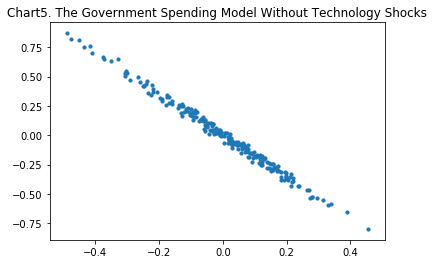

In [70]:
# Simulation(Without Z shock)
Zt_pre = Zbar
Gt_pre = Gbar
Kt_pre = Kbar
periods = 220

#Z_shocks = np.random.normal(0,sigma,periods)
Z_shocks = np.zeros(periods)
G_shocks = np.random.normal(0,sigma_v,periods)
K_f_series = np.zeros(periods)
H_series = np.zeros(periods)
Z_series = np.zeros(periods)
G_series = np.zeros(periods)

for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    Gt_pre = (1-lamb)*Gbar + lamb*Gt_pre + G_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Gt_pre,Kt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    H_series[t] = d_t[1]
    K_f_series[t] = Kt_pre
    Z_series[t] = Zt_pre
    G_series[t] = Gt_pre


K_series = np.append(Kbar, K_f_series[:-1])
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series - np.exp(G_series)
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta

K_series,_ = sm.tsa.filters.hpfilter(np.log(K_series), 1600)
Y_series,_ = sm.tsa.filters.hpfilter(np.log(Y_series), 1600)
I_series,_ = sm.tsa.filters.hpfilter(np.log(I_series), 1600)
C_series,_ = sm.tsa.filters.hpfilter(np.log(C_series), 1600)
H_series,_ = sm.tsa.filters.hpfilter(np.log(H_series), 1600)
Y_H_series,_ = sm.tsa.filters.hpfilter(np.log(Y_H_series), 1600)
R_series,_ = sm.tsa.filters.hpfilter(np.log(R_series), 1600)

plt.scatter(Y_H_series*100, Y_series*100, s=10)
plt.title('Chart5. The Government Spending Model Without Technology Shocks')
plt.show()

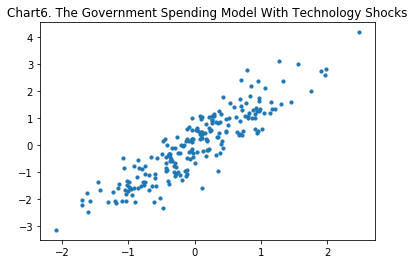

In [71]:
# Simulation(With Z shock)
Zt_pre = Zbar
Gt_pre = Gbar
Kt_pre = Kbar
periods = 220

Z_shocks = np.random.normal(0,sigma,periods)
#Z_shocks = np.zeros(periods)
G_shocks = np.random.normal(0,sigma_v,periods)
K_f_series = np.zeros(periods)
H_series = np.zeros(periods)
Z_series = np.zeros(periods)
G_series = np.zeros(periods)

for t in range(periods):
    Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[t]
    Gt_pre = (1-lamb)*Gbar + lamb*Gt_pre + G_shocks[t]
    d_t = policy_f @ np.array([1,Zt_pre,Gt_pre,Kt_pre])[:,np.newaxis]
    Kt_pre = d_t[0]
    H_series[t] = d_t[1]
    K_f_series[t] = Kt_pre
    Z_series[t] = Zt_pre
    G_series[t] = Gt_pre


K_series = np.append(Kbar, K_f_series[:-1])
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series - np.exp(G_series)
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta

K_series,_ = sm.tsa.filters.hpfilter(np.log(K_series), 1600)
Y_series,_ = sm.tsa.filters.hpfilter(np.log(Y_series), 1600)
I_series,_ = sm.tsa.filters.hpfilter(np.log(I_series), 1600)
C_series,_ = sm.tsa.filters.hpfilter(np.log(C_series), 1600)
H_series,_ = sm.tsa.filters.hpfilter(np.log(H_series), 1600)
Y_H_series,_ = sm.tsa.filters.hpfilter(np.log(Y_H_series), 1600)
R_series,_ = sm.tsa.filters.hpfilter(np.log(R_series), 1600)

plt.scatter(Y_H_series*100, Y_series*100, s=10)
plt.title('Chart6. The Government Spending Model With Technology Shocks')
plt.show()

In [72]:
# Repeat Simulation
rep = 100
periods = 240

Z_shocks = np.random.normal(0,sigma,(rep,periods))
G_shocks = np.random.normal(0,sigma_v,(rep,periods))
K_f_series = np.zeros((rep,periods))
H_series = np.zeros((rep,periods))
Z_series = np.zeros((rep,periods))
G_series = np.zeros((rep,periods))

for rr in range(rep):
    Zt_pre = Zbar
    Gt_pre = Gbar
    Kt_pre = Kbar
    for t in range(periods):
        Zt_pre = (1-rho)*Zbar + rho*Zt_pre + Z_shocks[rr, t]
        Gt_pre = (1-lamb)*Gbar + lamb*Gt_pre + G_shocks[rr, t]
        d_t = policy_f @ np.array([1,Zt_pre,Gt_pre,Kt_pre])[:,np.newaxis]
        Kt_pre = d_t[0]
        H_series[rr,t] = d_t[1]
        K_f_series[rr,t] = Kt_pre
        Z_series[rr,t] = Zt_pre
        G_series[rr,t] = Gt_pre

K_series = np.append(np.ones((rep,1))*Kbar, K_f_series[:,:-1], axis=1)
Y_series = np.exp(Z_series)*K_series**theta*H_series**(1-theta)
I_series = K_f_series - (1-delta)*K_series
C_series = Y_series - I_series - np.exp(G_series)
Y_H_series = Y_series/H_series
R_series = Y_series/K_series*theta-delta

simdata = {}; sim_sd={}
simlist = ['Y','C','I','H','Y_H','R']
varseries = [Y_series, C_series, I_series, H_series, Y_H_series, R_series]
for i, ser in enumerate(varseries):
    for rr in range(rep):
        cycle,_ = sm.tsa.filters.hpfilter(np.log(ser[rr,:]), 1600)
        ser[rr,:] = cycle
    simdata[simlist[i]] = np.mean(ser, axis=0)
    sim_sd[simlist[i]] = np.mean(np.std(ser, axis=1))

for rr in range(rep):
    if rr==0:
        stat = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
    else:
        tmp = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
        stat += tmp
stat= stat/rep
stat= stat.round(2)

corr_h_w = np.zeros(rep)
for rr in range(rep):
    corr_h_w[rr] = np.corrcoef(H_series[rr,:], Y_H_series[rr,:])[0,1]
    
print('%% S.D of Y : %0.2f' % (sim_sd['Y']*100))
print('S.D of C vs Y : %0.2f' % (sim_sd['C']/sim_sd['Y']))
print('S.D of I vs Y : %0.2f' % (sim_sd['I']/sim_sd['Y']))
print('S.D of H vs Y : %0.2f' % (sim_sd['H']/sim_sd['Y']))
print('S.D of Y_H vs Y : %0.2f' % (sim_sd['Y_H']/sim_sd['Y']))
print('S.D of H vs Y_H : %0.2f' % (sim_sd['H']/sim_sd['Y_H']))
print('Corr(H, Y_H)    : %0.2f' % (np.mean(corr_h_w)))

% S.D of Y : 1.24
S.D of C vs Y : 0.53
S.D of I vs Y : 3.05
S.D of H vs Y : 0.55
S.D of Y_H vs Y : 0.61
S.D of H vs Y_H : 0.90
Corr(H, Y_H)    : 0.50


In [73]:
stat

,SD,RelativeSD,Autocorr,CrossCorr-2,CrossCorr-1,CrossCorr,CrossCorr+1,CrossCorr+2
Y,1.25,1.00,0.70,0.45,0.70,1.00,0.70,0.45
C,0.67,0.54,0.74,0.15,0.34,0.57,0.48,0.38
I,3.81,3.05,0.69,0.45,0.67,0.94,0.62,0.37
H,0.68,0.55,0.70,0.44,0.63,0.85,0.54,0.30
Y_H,0.76,0.61,0.72,0.33,0.58,0.88,0.66,0.47
R,4.47,3.59,0.69,0.51,0.72,0.97,0.60,0.31


### 5. Home Production

Set parameters 

In [74]:
beta = 0.99; theta = 0.36; delta = 0.025; rho = 0.95; sigma_m = 0.007
sigma_h = 0.007; eta =  0.08; e = 0.8; gamma = 2/3;
sigma_mh = gamma*sigma_m*sigma_h

Solve for Steady State

In [75]:
Hmbar = 0.33; Hhbar = 0.28
Zmbar = 0; Zhbar = 0
K_Hm = ((1/beta-1+delta)/theta/np.exp(Zmbar))**(1/(theta-1))
Kmbar = K_Hm*Hmbar
#K_Hh = eta*(1-theta)/(1-eta)*np.exp(Zmbar)/np.exp(Zhbar)*(K_Hm**theta)/(1/beta-1+delta)
K_Hh = np.exp(Zmbar)/np.exp(Zhbar)/theta/(1-eta)*eta*(1-theta)*K_Hm
Khbar = K_Hh*Hhbar

Ymbar = np.exp(Zmbar)*Kmbar**theta*Hmbar**(1-theta)
Yhbar = np.exp(Zhbar)*Khbar**eta*Hhbar**(1-eta)
Cmbar = Ymbar - delta*(Kmbar + Khbar)
Chbar = Yhbar

#tmp_a = (Chbar/Cmbar)**(e-1)*(1-eta)*Yhbar/Hhbar
#a = tmp_a/((1-theta)*Ymbar/Hmbar+tmp_a)
tmp_a = eta*K_Hh**(eta-1)
a = tmp_a/((1/beta-1+delta)*(Chbar/Cmbar)**(1-e)+tmp_a)
Cbar = (a*Cmbar**e + (1-a)*Chbar**e)**(1/e)
mu = (1-theta)*np.exp(Zmbar)*K_Hm**theta*a*(Cbar/Cmbar)**(1-e)/Cbar*(1-Hmbar-Hhbar)
#mu = (1-eta)*Yhbar/Hhbar/Chbar/(a/(1-a)*(Cmbar/Chbar)**e+1)*(1-Hmbar-Hhbar)

sigmaM = np.array([[sigma_m**2, sigma_mh],[sigma_mh, sigma_h**2]])
print('Km/Hmbar: %0.2f' %K_Hm)
print('Kh/Hhbar: %0.2f' %K_Hh)
print('Kmbar   : %0.2f' %Kmbar)
print('Khbar   : %0.2f' %Khbar)
print('Ymbar: %0.2f' %Ymbar)
print('Yhbar: %0.2f' %Yhbar)
print('Cmbar: %0.2f' %Cmbar)
print('Ch/Y : %0.2f' %(Chbar/Ymbar))
print('a    : %0.2f' %a)
print('mu   : %0.2f' %mu)
print('Var-Cov matrix :')
print(sigmaM)

Km/Hmbar: 37.99
Kh/Hhbar: 5.87
Kmbar   : 12.54
Khbar   : 1.64
Ymbar: 1.22
Yhbar: 0.32
Cmbar: 0.87
Ch/Y : 0.26
a    : 0.35
mu   : 0.58
Var-Cov matrix :
[[4.90000000e-05 3.26666667e-05]
 [3.26666667e-05 4.90000000e-05]]


In [76]:
Khbar/Kmbar

0.13116673986239205

In [77]:
def fnU(var): # solve for utility fn. value given Wmat
    [Zm, Zh, Km, Kh, Km_, Kh_, Hm, Hh] = var
    Cm = np.exp(Zm)*Km**theta*Hm**(1-theta)+(1-delta)*(Km+Kh)-(Km_+Kh_)
    Ch = np.exp(Zh)*Kh**eta*Hh**(1-eta)
    C = (a*Cm**e + (1-a)*Ch**e)**(1/e)
    return np.log(C) + mu*np.log(1-Hm-Hh)

In [78]:
fnU([Zmbar, Zhbar, Kmbar, Khbar, Kmbar, Khbar, Hmbar, Hhbar])

-1.235693687266468

In [79]:
# Make Q
Wbar = np.array([Zmbar, Zhbar, Kmbar, Khbar, Kmbar, Khbar, Hmbar, Hhbar])[:,np.newaxis]
Rmat = fnU(list(Wbar))
Jmat, Hmat = fnJH(fnU, list(Wbar))

Q11 = Rmat -Wbar.T@Jmat +Wbar.T@Hmat@Wbar/2
Q12 = (Jmat-Hmat@Wbar)/2
Q22 = Hmat/2
Q = np.concatenate((np.concatenate((Q11,Q12.T),axis=1),np.concatenate((Q12,Q22),axis=1)),axis=0)
Q

array([[-2.53750895,  0.38458815,  0.22697385,  0.63557358,  0.63557154,
        -0.6292104 , -0.62919843,  1.91229112,  1.91229935],
       [ 0.38458815,  0.03961498, -0.13965801, -0.27400415, -0.28193448,
         0.28219371,  0.28219455,  0.07682688, -0.45887572],
       [ 0.22697385, -0.13965801,  0.0991518 , -0.11540852, -0.10657419,
         0.11425499,  0.11425472, -0.2708514 ,  0.32578662],
       [ 0.63557358, -0.27400415, -0.11540852, -0.23611668, -0.23298197,
         0.23319652,  0.23319652, -0.53139798, -0.37919945],
       [ 0.63557154, -0.28193448, -0.10657419, -0.23298197, -0.23678504,
         0.23065133,  0.23065078, -0.54678068, -0.35017267],
       [-0.6292104 ,  0.28219371,  0.11425499,  0.23319652,  0.23065133,
        -0.23086422, -0.23086422,  0.54728694,  0.37540748],
       [-0.62919843,  0.28219455,  0.11425472,  0.23319652,  0.23065078,
        -0.23086422, -0.23087088,  0.54728638,  0.37540776],
       [ 1.91229112,  0.07682688, -0.2708514 , -0.53139798, -0

In [80]:
# Number of variables
l_exo = 2
l_state = 2
l_f = 1+ l_exo+l_state
l_d = 4
l_all = l_f+l_d

In [81]:
# Make B
B = np.zeros((l_f ,l_f+l_d))
B[0,0] =1
B[np.arange(1,l_exo+1),np.arange(1,l_exo+1)] = [rho, rho]
B[1:1+l_exo,0] = [(1-rho)*Zmbar, (1-rho)*Zhbar]
B[np.arange(1+l_exo,1+l_exo+l_state), np.arange(1+l_exo+l_state,1+l_exo+l_state+l_state)]=1
print(B)

[[1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.95 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.95 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.  ]]


In [82]:
tol = 0.0001

P0 = np.ones((l_f,l_f))
#P0 = np.zeros((l_f,l_f))
Ppre = P0

start_time = time.time()
for i in range(2000):
    Msigma = np.zeros((B.shape[1],B.shape[1]))
    Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@(np.identity(2)@sigmaM))
    #If there are more than 2 exo shocks, then modify above line

    M = B.T@Ppre@B + Msigma
    #M
    
    P = Q[:l_f,:l_f] + beta*M[:l_f,:l_f] -((Q[:l_f,l_f:]+beta*M[:l_f,l_f:]) @ np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @\
        (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T)
    dist = np.max(np.abs(P.flatten() - Ppre.flatten()))
    if dist < tol:
        print('Total number of iterations: %d' %(i+1))
        print('Total running time: %0.3f seconds' % (time.time() - start_time))
        print('       ')
        Msigma = np.zeros((B.shape[1],B.shape[1]))
        Msigma[0,0] = np.trace(Ppre[1:1+l_exo, 1:1+l_exo]@(np.identity(2)@sigmaM))
        #If there are more than 2 exo shocks, then modify above line
        M = B.T@P@B + Msigma
        break
    Ppre = P
    if (i+1)%1000 ==0:
        print('%d times running' %(i+1))
        print('Iteration gap : %0.3f' %(dist))
        if i==1999:
            print('The maximum iteration number has reached')
            print('Total running time: %0.3f seconds' % (time.time() - start_time))
            print('       ')

policy_f = -np.linalg.inv(Q[l_f:,l_f:]+beta*M[l_f:,l_f:]) @ (Q[:l_f,l_f:]+beta*M[:l_f,l_f:]).T
policy_f # policy fn. shape(d,s)

Total number of iterations: 946
Total running time: 0.060 seconds
       


array([[-2.55239946e-01,  6.60940730e+00, -3.91836340e+00,
         9.05151886e-01,  8.78331915e-01],
       [ 8.52328460e-01, -4.83686802e+00,  3.85940375e+00,
         5.60569057e-02,  5.42960086e-02],
       [ 2.97887758e-01,  4.94512149e-01, -3.06118078e-01,
         5.23312705e-03, -2.03681043e-02],
       [ 3.71338527e-01, -3.36391592e-01,  3.31335377e-01,
        -9.41939202e-03,  1.62659944e-02]])

In [83]:
print(policy_f @ np.array([1, Zmbar, Zhbar, Kmbar, Khbar])[:,np.newaxis])
print([1,Zmbar, Zhbar, Kmbar, Khbar, Kmbar, Khbar, Hmbar, Hhbar])

[[12.53645367]
 [ 1.64436576]
 [ 0.33      ]
 [ 0.28      ]]
[1, 0, 0, 12.536453667590242, 1.64436575701374, 12.536453667590242, 1.64436575701374, 0.33, 0.28]


In [84]:
def plot_irf(txt):
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(231)
    plt.plot(np.arange(220),Ym_series)
    plt.title('Y%s' %txt)
    plt.subplot(232)
    plt.plot(np.arange(220),C_series)
    plt.title('C%s' %txt)
    plt.subplot(233)
    plt.plot(np.arange(220),I_series)
    plt.title('I%s' %txt)
    plt.subplot(234)
    plt.plot(np.arange(220),K_series)
    plt.title('K%s' %txt)
    plt.subplot(235)
    plt.plot(np.arange(220),Y_H_series)
    plt.title('Y/H%s' %txt)
    plt.subplot(236)
    plt.plot(np.arange(220),R_series)
    plt.title('R%s' %txt)
    plt.tight_layout()
    plt.show()

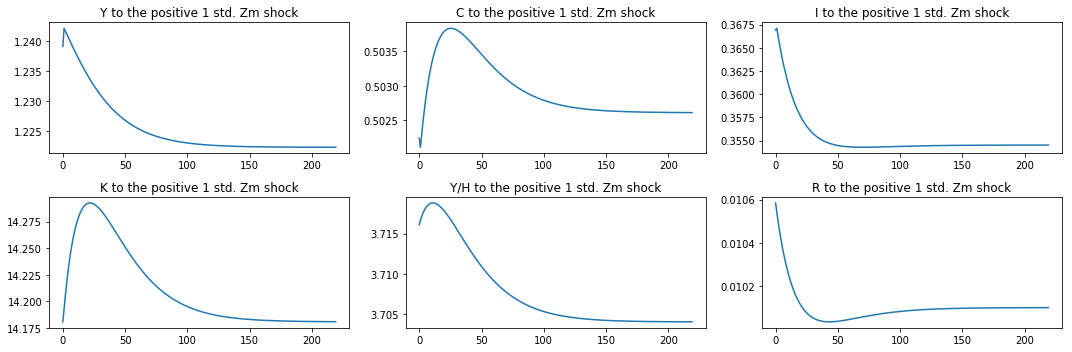

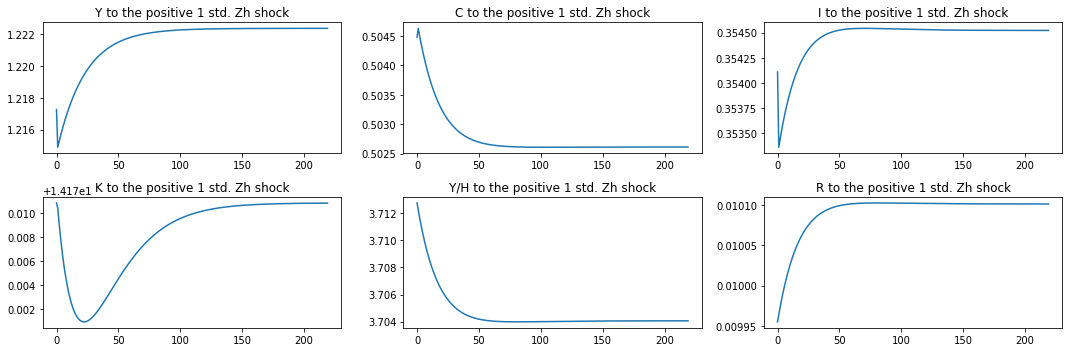

In [85]:
# Impulse response to Z innovation size 1
Zmt_pre = Zmbar
Zht_pre = Zhbar
Kmt_pre = Kmbar
Kht_pre = Khbar
periods = 220

Zm_shocks = np.array([1*sigma_m]+[0]*(periods-1))
Zh_shocks = np.array([0]+[0]*(periods-1))

Km_f_series = np.zeros(periods); Kh_f_series = np.zeros(periods)
Hm_series = np.zeros(periods); Hh_series = np.zeros(periods)
Zm_series = np.zeros(periods); Zh_series = np.zeros(periods)
for t in range(periods):
    Zmt_pre = (1-rho)*Zmbar + rho*Zmt_pre + Zm_shocks[t]
    Zht_pre = (1-rho)*Zhbar + rho*Zht_pre + Zh_shocks[t]
    d_t = policy_f @ np.array([1,Zmt_pre,Zht_pre,Kmt_pre,Kht_pre])[:,np.newaxis]
    Kmt_pre = d_t[0]
    Kht_pre = d_t[1]
    Hm_series[t] = d_t[2]
    Hh_series[t] = d_t[3]
    Km_f_series[t] = Kmt_pre
    Kh_f_series[t] = Kht_pre
    Zm_series[t] = Zmt_pre
    Zh_series[t] = Zht_pre

Km_series = np.append(Kmbar, Km_f_series[:-1])
Kh_series = np.append(Khbar, Kh_f_series[:-1])
K_f_series = Km_f_series+Kh_f_series
K_series = Km_series+Kh_series
Ym_series = np.exp(Zm_series)*Km_series**theta*Hm_series**(1-theta)
Yh_series = np.exp(Zh_series)*Kh_series**eta*Hh_series**(1-eta)
I_series = K_f_series - (1-delta)*K_series
Cm_series = Ym_series - I_series
C_series = (a*Cm_series**e + (1-a)*Yh_series**e)**(1/e)
Y_H_series = Ym_series/Hm_series
R_series = Ym_series/Km_series*theta-delta
plot_irf(' to the positive 1 std. Zm shock')   

# Impulse response to G innovation size 1
Zmt_pre = Zmbar
Zht_pre = Zhbar
Kmt_pre = Kmbar
Kht_pre = Khbar

Zm_shocks = np.array([0*sigma_m]+[0]*(periods-1))
Zh_shocks = np.array([1*sigma_h]+[0]*(periods-1))

Km_f_series = np.zeros(periods); Kh_f_series = np.zeros(periods)
Hm_series = np.zeros(periods); Hh_series = np.zeros(periods)
Zm_series = np.zeros(periods); Zh_series = np.zeros(periods)
for t in range(periods):
    Zmt_pre = (1-rho)*Zmbar + rho*Zmt_pre + Zm_shocks[t]
    Zht_pre = (1-rho)*Zhbar + rho*Zht_pre + Zh_shocks[t]
    d_t = policy_f @ np.array([1,Zmt_pre,Zht_pre,Kmt_pre,Kht_pre])[:,np.newaxis]
    Kmt_pre = d_t[0]
    Kht_pre = d_t[1]
    Hm_series[t] = d_t[2]
    Hh_series[t] = d_t[3]
    Km_f_series[t] = Kmt_pre
    Kh_f_series[t] = Kht_pre
    Zm_series[t] = Zmt_pre
    Zh_series[t] = Zht_pre
    
Km_series = np.append(Kmbar, Km_f_series[:-1])
Kh_series = np.append(Khbar, Kh_f_series[:-1])
K_f_series = Km_f_series+Kh_f_series
K_series = Km_series+Kh_series
Ym_series = np.exp(Zm_series)*Km_series**theta*Hm_series**(1-theta)
Yh_series = np.exp(Zh_series)*Kh_series**eta*Hh_series**(1-eta)
I_series = K_f_series - (1-delta)*K_series
Cm_series = Ym_series - I_series
C_series = (a*Cm_series**e + (1-a)*Yh_series**e)**(1/e)
Y_H_series = Ym_series/Hm_series
R_series = Ym_series/Km_series*theta-delta
plot_irf(' to the positive 1 std. Zh shock')   

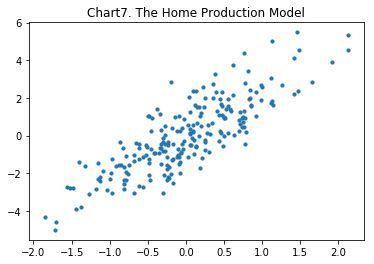

In [86]:
# Simulation
rep = 1
periods = 220

shocks = np.random.multivariate_normal([0,0],sigmaM,(rep,periods))
Zm_shocks = shocks[:,:,0]
Zh_shocks = shocks[:,:,1]
Km_f_series = np.zeros((rep,periods))
Kh_f_series = np.zeros((rep,periods))
Hm_series = np.zeros((rep,periods))
Hh_series = np.zeros((rep,periods))
Zm_series = np.zeros((rep,periods))
Zh_series = np.zeros((rep,periods))

for rr in range(rep):
    Zmt_pre = Zmbar
    Zht_pre = Zhbar
    Kmt_pre = Kmbar
    Kht_pre = Khbar
    for t in range(periods):
        Zmt_pre = (1-rho)*Zmbar + rho*Zmt_pre + Zm_shocks[rr, t]
        Zht_pre = (1-rho)*Zhbar + rho*Zht_pre + Zh_shocks[rr, t]
        d_t = policy_f @ np.array([1,Zmt_pre,Zht_pre,Kmt_pre,Kht_pre])[:,np.newaxis]
        Kmt_pre = d_t[0]
        Kht_pre = d_t[1]
        Hm_series[rr, t] = d_t[2]
        Hh_series[rr, t] = d_t[3]
        Km_f_series[rr, t] = Kmt_pre
        Kh_f_series[rr, t] = Kht_pre
        Zm_series[rr, t] = Zmt_pre
        Zh_series[rr, t] = Zht_pre

Km_series = np.append(np.ones((rep,1))*Kmbar, Km_f_series[:,:-1], axis=1)
Kh_series = np.append(np.ones((rep,1))*Khbar, Kh_f_series[:,:-1], axis=1)
K_f_series = Km_f_series+Kh_f_series
K_series = Km_series+Kh_series
Ym_series = np.exp(Zm_series)*Km_series**theta*Hm_series**(1-theta)
Yh_series = np.exp(Zh_series)*Kh_series**eta*Hh_series**(1-eta)
I_series = K_f_series - (1-delta)*K_series
Cm_series = Ym_series - I_series
C_series = (a*Cm_series**e + (1-a)*Yh_series**e)**(1/e)
Y_H_series = Ym_series/Hm_series
R_series = Ym_series/Km_series*theta-delta

K_series,_ = sm.tsa.filters.hpfilter(np.log(K_series), 1600)
Y_series,_ = sm.tsa.filters.hpfilter(np.log(Ym_series), 1600)
I_series,_ = sm.tsa.filters.hpfilter(np.log(I_series), 1600)
C_series,_ = sm.tsa.filters.hpfilter(np.log(Cm_series), 1600)
H_series,_ = sm.tsa.filters.hpfilter(np.log(Hm_series), 1600)
Y_H_series,_ = sm.tsa.filters.hpfilter(np.log(Y_H_series), 1600)
R_series,_ = sm.tsa.filters.hpfilter(np.log(R_series), 1600)

plt.scatter(Y_H_series*100, Y_series*100, s=10)
plt.title('Chart7. The Home Production Model')
plt.show()

In [87]:
rep = 100
periods = 220

np.random.multivariate_normal([0,0],sigmaM,(rep,periods)).shape

(100, 220, 2)

In [88]:
# Repeat Simulation
rep = 100
periods = 240

shocks = np.random.multivariate_normal([0,0],sigmaM,(rep,periods))
Zm_shocks = shocks[:,:,0]
Zh_shocks = shocks[:,:,1]
Km_f_series = np.zeros((rep,periods))
Kh_f_series = np.zeros((rep,periods))
Hm_series = np.zeros((rep,periods))
Hh_series = np.zeros((rep,periods))
Zm_series = np.zeros((rep,periods))
Zh_series = np.zeros((rep,periods))

for rr in range(rep):
    Zmt_pre = Zmbar
    Zht_pre = Zhbar
    Kmt_pre = Kmbar
    Kht_pre = Khbar
    for t in range(periods):
        Zmt_pre = (1-rho)*Zmbar + rho*Zmt_pre + Zm_shocks[rr, t]
        Zht_pre = (1-rho)*Zhbar + rho*Zht_pre + Zh_shocks[rr, t]
        d_t = policy_f @ np.array([1,Zmt_pre,Zht_pre,Kmt_pre,Kht_pre])[:,np.newaxis]
        Kmt_pre = d_t[0]
        Kht_pre = d_t[1]
        Hm_series[rr, t] = d_t[2]
        Hh_series[rr, t] = d_t[3]
        Km_f_series[rr, t] = Kmt_pre
        Kh_f_series[rr, t] = Kht_pre
        Zm_series[rr, t] = Zmt_pre
        Zh_series[rr, t] = Zht_pre

Km_series = np.append(np.ones((rep,1))*Kmbar, Km_f_series[:,:-1], axis=1)
Kh_series = np.append(np.ones((rep,1))*Khbar, Kh_f_series[:,:-1], axis=1)
K_f_series = Km_f_series+Kh_f_series
K_series = Km_series+Kh_series
Ym_series = np.exp(Zm_series)*Km_series**theta*Hm_series**(1-theta)
Yh_series = np.exp(Zh_series)*Kh_series**eta*Hh_series**(1-eta)
I_series = K_f_series - (1-delta)*K_series
Cm_series = Ym_series - I_series
C_series = (a*Cm_series**e + (1-a)*Yh_series**e)**(1/e)
Y_H_series = Ym_series/Hm_series
R_series = Ym_series/Km_series*theta-delta

simdata = {}; sim_sd={}
simlist = ['Y','C','I','H','Y_H','R']
varseries = [Ym_series, Cm_series, I_series, Hm_series, Y_H_series, R_series]
for i, ser in enumerate(varseries):
    for rr in range(rep):
        cycle,_ = sm.tsa.filters.hpfilter(np.log(ser[rr,:]), 1600)
        ser[rr,:] = cycle
    simdata[simlist[i]] = np.mean(ser, axis=0)
    sim_sd[simlist[i]] = np.mean(np.std(ser, axis=1))

for rr in range(rep):
    if rr==0:
        stat = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
    else:
        tmp = Stat(pd.DataFrame({simlist[i]:varseries[i][rr,:] for i in range(len(simlist))}))
        stat += tmp
stat= stat/rep
stat= stat.round(2)

corr_h_w = np.zeros(rep)
for rr in range(rep):
    corr_h_w[rr] = np.corrcoef(Hm_series[rr,:], Y_H_series[rr,:])[0,1]
    
print('%% S.D of Y : %0.2f' % (sim_sd['Y']*100))
print('S.D of C vs Y : %0.2f' % (sim_sd['C']/sim_sd['Y']))
print('S.D of I vs Y : %0.2f' % (sim_sd['I']/sim_sd['Y']))
print('S.D of H vs Y : %0.2f' % (sim_sd['H']/sim_sd['Y']))
print('S.D of Y_H vs Y : %0.2f' % (sim_sd['Y_H']/sim_sd['Y']))
print('S.D of H vs Y_H : %0.2f' % (sim_sd['H']/sim_sd['Y_H']))
print('Corr(H, Y_H)    : %0.2f' % (np.mean(corr_h_w)))

% S.D of Y : 1.67
S.D of C vs Y : 0.52
S.D of I vs Y : 2.78
S.D of H vs Y : 0.73
S.D of Y_H vs Y : 0.40
S.D of H vs Y_H : 1.82
Corr(H, Y_H)    : 0.51


In [89]:
stat

,SD,RelativeSD,Autocorr,CrossCorr-2,CrossCorr-1,CrossCorr,CrossCorr+1,CrossCorr+2
Y,1.67,1.00,0.77,0.51,0.77,1.00,0.77,0.51
C,0.87,0.52,0.85,0.21,0.44,0.67,0.71,0.59
I,4.66,2.79,0.72,0.54,0.76,0.94,0.63,0.36
H,1.22,0.73,0.79,0.49,0.74,0.94,0.73,0.47
Y_H,0.67,0.40,0.73,0.37,0.57,0.78,0.58,0.41
R,5.26,3.15,0.70,0.58,0.79,0.94,0.59,0.30
